In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold,  StratifiedShuffleSplit
from sklearn.preprocessing import KBinsDiscretizer, RobustScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm.notebook import tqdm ,tnrange

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
# Python Method 1 : Displays Data Information :
# Need to convert float64 to int for Catboost Classifier
def display_data_information(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes
        if len(data_type) > 0 :
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        

# Display Data Information of "train" :

data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
display_data_information(train, data_types, "train")

 Information of  train : Rows =  381109 | Columns =  12 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


3 float64 Features
Region_Code        

In [4]:
display_data_information(test, data_types, "test")

 Information of  test : Rows =  127037 | Columns =  11 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


3 float64 Features
Region_Code             float64
Annual_Premium          float64
Policy_S

In [5]:
def display_head_tail(data, head_rows, tail_rows):
    display("Data Head & Tail :")
    display(data.head(head_rows).append(data.tail(tail_rows)))
display_head_tail(train, 5, 5)

'Data Head & Tail :'

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0
381108,381109,Male,46,1,29.0,0,1-2 Year,No,41777.0,26.0,237,0


In [6]:
display_head_tail(test, 5, 5)

'Data Head & Tail :'

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265
127036,508146,Male,41,1,29.0,1,1-2 Year,No,27927.0,124.0,231


In [7]:
# Python Method 3 : Displays Data Description using Statistics :

def display_data_description(data, numeric_data_types, categorical_data_types):
    
    print("Data Description :")
    display(data.describe( include = numeric_data_types))
    print("")
    display(data.describe( include = categorical_data_types))

# Display Data Description of "train" :
data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]

display_data_description(train, data_types[0:4], data_types[4:7])

Data Description :


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


In [8]:
# Python Method 4 : Removes Data Duplicates while Retaining the First one - Similar to SQL DISTINCT :

def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return data
remove_duplicate(train)

BEFORE REMOVING DUPLICATES - No. of Rows =  381109
AFTER REMOVING DUPLICATES  - No. of Rows =  381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [9]:
# Python Method 5 : Fills or Imputes Missing values with Various Methods : 

def fill_missing_values(data, fill_value, fill_types, columns, dataframe_name):
    
    print("Missing Values BEFORE REMOVAL in ",dataframe_name," data")
    display(data.isnull().sum())
    for column in columns :
        
        # Fill Missing Values with Specific Value :
        if "Value_Fill" in fill_types :
            data[ column ] = data[ column ].fillna(fill_value)
#             print("Value_Fill")

        # Fill Missing Values with Forward Fill  (Previous Row Value as Current Row in Table) :
        if "Forward_Fill" in fill_types :
            data[ column ] = data[ column ].ffill(axis = 0)
#             print("Forward_Fill")

        # Fill Missing Values with Backward Fill (Next Row Value as Current Row in Table) :
        if "Backward_Fill" in fill_types :
            data[ column ] = data[ column ].bfill(axis = 0)
#             print("Backward_Fill")
    
    print("Missing Values AFTER REMOVAL in ",dataframe_name," data")
    display(data.isnull().sum())
    
    return data

fill_types = [ "Forward_Fill"]
fill_value = 0
# Fills or Imputes Missing values in "Registration_Date" Column with "Forward_Fill" Method in "train" : 
train = fill_missing_values(train, fill_value, fill_types, ["Gender"],"train")

# Fills or Imputes Missing values in "Registration_Date" Column with "Forward_Fill" Method in "train" :
test  = fill_missing_values(test, fill_value, fill_types, ["Gender"],"test")

# No Missing Values !!!

Missing Values BEFORE REMOVAL in  train  data


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Missing Values BEFORE REMOVAL in  test  data


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

Missing Values AFTER REMOVAL in  test  data


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [10]:
# Python Method 6 : Displays Unique Values in Each Column of the Dataframe(Table) :

def display_unique(data):
    for column in data.columns :
        
        print("No of Unique Values in "+column+" Column are : "+str(data[column].nunique()))
#         print("Actual Unique Values in "+column+" Column are : "+str(data[column].sort_values(ascending=True,na_position='last').unique() ))
#         print("NULL Values :")
#         print(data[ column ].isnull().sum())
        print("Value Counts :")
        print(data[column].value_counts())
        print("")
        
# Displays Unique Values in Each Column of "train" :
# Check "train" data for Values of each Column - Long Form :

display_unique(train)

No of Unique Values in id Column are : 381109
Value Counts :
2047      1
295621    1
84604     1
82557     1
88702     1
         ..
107934    1
109983    1
21920     1
23969     1
2049      1
Name: id, Length: 381109, dtype: int64

No of Unique Values in Gender Column are : 2
Value Counts :
Male      206089
Female    175020
Name: Gender, dtype: int64

No of Unique Values in Age Column are : 66
Value Counts :
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: Age, Length: 66, dtype: int64

No of Unique Values in Driving_License Column are : 2
Value Counts :
1    380297
0       812
Name: Driving_License, dtype: int64

No of Unique Values in Region_Code Column are : 53
Value Counts :
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       62

In [11]:
for i in train:
    print(f"column {i} unique values {train[i].unique()}")

column id unique values [     1      2      3 ... 381107 381108 381109]
column Gender unique values ['Male' 'Female']
column Age unique values [44 76 47 21 29 24 23 56 32 41 71 37 25 42 60 65 49 34 51 26 57 79 48 45
 72 30 54 27 38 22 78 20 39 62 58 59 63 50 67 77 28 69 52 31 33 43 36 53
 70 46 55 40 61 75 64 35 66 68 74 73 84 83 81 80 82 85]
column Driving_License unique values [1 0]
column Region_Code unique values [28.  3. 11. 41. 33.  6. 35. 50. 15. 45.  8. 36. 30. 26. 16. 47. 48. 19.
 39. 23. 37.  5. 17.  2.  7. 29. 46. 27. 25. 13. 18. 20. 49. 22. 44.  0.
  9. 31. 12. 34. 21. 10. 14. 38. 24. 40. 43. 32.  4. 51. 42.  1. 52.]
column Previously_Insured unique values [0 1]
column Vehicle_Age unique values ['> 2 Years' '1-2 Year' '< 1 Year']
column Vehicle_Damage unique values ['Yes' 'No']
column Annual_Premium unique values [ 40454.  33536.  38294. ...  20706. 101664.  69845.]
column Policy_Sales_Channel unique values [ 26. 152. 160. 124.  14.  13.  30. 156. 163. 157. 122.  19.  22.  

In [12]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test])

vehicle_age = {'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}
data['Vehicle_Age'] = data['Vehicle_Age'].map(vehicle_age)
gender = {'Male':1, 'Female':0}
data['Gender'] = data['Gender'].map(gender)
vehicle_damage = {'Yes':1, 'No':0}
data['Vehicle_Damage'] = data['Vehicle_Damage'].map(vehicle_damage)
data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,train
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,train
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,train
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,train
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,1,37.0,1,0,0,30867.0,152.0,56,NaN,test
127033,508143,0,38,1,28.0,0,1,1,28700.0,122.0,165,NaN,test
127034,508144,1,21,1,46.0,1,0,0,29802.0,152.0,74,NaN,test
127035,508145,1,71,1,28.0,1,1,0,62875.0,26.0,265,NaN,test


In [13]:
# New Aggregated Features

data['Vehicle_Age_Region_per_Damage'] = data.groupby(['Region_Code', 'Vehicle_Age'])['Vehicle_Damage'].transform('sum')
data['Term'] = data['Vintage']/365
data['Vehicle_Region_Policy_Damage'] = data.groupby(['Region_Code', 'Policy_Sales_Channel'])['Vehicle_Damage'].transform('sum')
data.loc[(data['Vehicle_Age'] == 2) & (data['Vehicle_Damage'] == 1), 'Old_Vehicle'] = 1
data.loc[(data['Vehicle_Age'] != 2) & (data['Vehicle_Damage'] == 0), 'Old_Vehicle'] = 0
data['Annual_Premium'] = np.log(data['Annual_Premium'])
data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,source,Vehicle_Age_Region_per_Damage,Term,Vehicle_Region_Policy_Damage,Old_Vehicle
0,1,1,44,1,28.0,0,2,1,10.607921,26.0,217,1.0,train,12742,0.594521,36878,1.0
1,2,1,76,1,3.0,0,1,0,10.420375,26.0,183,0.0,train,3875,0.501370,1330,0.0
2,3,1,47,1,28.0,0,2,1,10.553049,26.0,27,1.0,train,12742,0.073973,36878,1.0
3,4,1,21,1,11.0,1,0,0,10.261826,152.0,203,0.0,train,1186,0.556164,819,0.0
4,5,0,29,1,41.0,1,0,0,10.221796,152.0,39,0.0,train,2640,0.106849,1830,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,26,1,37.0,1,0,0,10.337443,152.0,56,NaN,test,2319,0.153425,1645,0.0
127033,508143,0,38,1,28.0,0,1,1,10.264652,122.0,165,NaN,test,71615,0.452055,7722,NaN
127034,508144,1,21,1,46.0,1,0,0,10.302331,152.0,74,NaN,test,3128,0.202740,1782,0.0
127035,508145,1,71,1,28.0,1,1,0,11.048904,26.0,265,NaN,test,71615,0.726027,36878,0.0


In [14]:
final_train = data.loc[data['source'] == 'train']
final_test = data.loc[data['source'] == 'test']
y = final_train['Response']
X = final_train.drop(columns=['id', 'Response', 'source'])
id_test = final_test['id']
final_test = final_test.drop(columns=['id', 'Response', 'source'])

In [15]:
final_test

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_Region_per_Damage,Term,Vehicle_Region_Policy_Damage,Old_Vehicle
0,1,25,1,11.0,1,0,0,10.485312,152.0,53,1186,0.145205,819,0.0
1,1,40,1,28.0,0,1,1,10.427091,7.0,111,71615,0.304110,33,NaN
2,1,47,1,28.0,0,1,1,10.597884,124.0,199,71615,0.545205,26157,NaN
3,1,24,1,27.0,1,0,1,10.528249,152.0,187,1223,0.512329,867,NaN
4,1,27,1,28.0,1,0,0,10.986935,152.0,297,9410,0.813699,4369,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,0,26,1,37.0,1,0,0,10.337443,152.0,56,2319,0.153425,1645,0.0
127033,0,38,1,28.0,0,1,1,10.264652,122.0,165,71615,0.452055,7722,NaN
127034,1,21,1,46.0,1,0,0,10.302331,152.0,74,3128,0.202740,1782,0.0
127035,1,71,1,28.0,1,1,0,11.048904,26.0,265,71615,0.726027,36878,0.0


In [16]:
def feature_importance(model, X_train):

    fI = model.feature_importances_
    
    print(fI)
    
    names = X_train.columns.values
    
    ticks = [i for i in range(len(names))]
    
    plt.bar(ticks, fI)
    
    plt.xticks(ticks, names,rotation = 90)
    
    plt.show()

 
####################################################################################################
Seed 1
Fold 0
Rows of Train=  266776 Rows of Holdout =  114333
[0]	validation_0-auc:0.70813	validation_0-logloss:0.66412
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 40 rounds.
[100]	validation_0-auc:0.85669	validation_0-logloss:0.27001
[200]	validation_0-auc:0.85829	validation_0-logloss:0.26459
[300]	validation_0-auc:0.85839	validation_0-logloss:0.26402
[400]	validation_0-auc:0.85834	validation_0-logloss:0.26397
Stopping. Best iteration:
[372]	validation_0-auc:0.85841	validation_0-logloss:0.26393

ROC_AUC=  0.8584130151957325
####################################################################################################
[0.00184642 0.01315594 0.00357991 0.0022704  0.5277199  0.01331897
 0.31448337 0.00185147 0.0139531  0.00116139 0.00248389 0.00117384
 0.0029437  0.100057

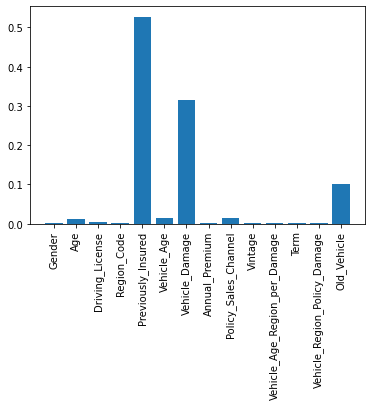

Fold 1
Rows of Train=  266776 Rows of Holdout =  114333
[0]	validation_0-auc:0.71239	validation_0-logloss:0.66403
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 40 rounds.
[100]	validation_0-auc:0.85818	validation_0-logloss:0.26994
[200]	validation_0-auc:0.85955	validation_0-logloss:0.26476
[300]	validation_0-auc:0.85961	validation_0-logloss:0.26416
Stopping. Best iteration:
[341]	validation_0-auc:0.85960	validation_0-logloss:0.26410

ROC_AUC=  0.859600458864183
####################################################################################################
Fold 2
Rows of Train=  266776 Rows of Holdout =  114333
[0]	validation_0-auc:0.70916	validation_0-logloss:0.66413
Multiple eval metrics have been passed: 'validation_0-logloss' will be used for early stopping.

Will train until validation_0-logloss hasn't improved in 40 rounds.
[100]	validation_0-auc:0.85671	validation_0-lo

In [17]:
# XGBoost Classifier
probs = np.zeros(shape=(len(final_test)))
scores = []
avg_loss = []

X_train, y_train = X, y
seeds = [1]

for seed in tnrange(len(seeds)):
    print(' ')
    print('#'*100)
    print('Seed', seeds[seed])
    sf = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=seed)
    for i, (idxT, idxV) in enumerate(sf.split(X_train, y_train)):
        print('Fold', i)
        print('Rows of Train= ', len(idxT), 'Rows of Holdout = ', len(idxV))
        clf = XGBClassifier(n_estimators=1000,
                           max_depth=6,
                           learning_rate=0.05,
                            subsample=0.9,
                            colsample_bytree=0.35,
                            objective='binary:logistic',
                            random_state=1)
        preds = clf.fit(X_train.iloc[idxT], y_train.iloc[idxT],
                       eval_set=[(X_train.iloc[idxV], y_train.iloc[idxV])],
                       verbose=100, eval_metric=['auc', 'logloss'],
                       early_stopping_rounds=40)
        probs_oof = clf.predict_proba(X_train.iloc[idxV])[:,1]
        probs += clf.predict_proba(final_test)[:,1]
        roc = roc_auc_score(y_train.iloc[idxV], probs_oof)
        scores.append(roc)
        avg_loss.append(clf.best_score)
        print("ROC_AUC= ", roc)
        print('#'*100)
        if i==0:
            feature_importance(clf,X_train)
        
print("Loss= {0:0.5f}, {1:0.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))
print('%.6f (%.6f)' % (np.array(scores).mean(), np.array(scores).std()))

In [18]:
sample = pd.read_csv("data/sample.csv")
sample['Response'] = probs/4
sample.to_csv('submission.csv',index =False)

In [19]:
import joblib
xgb_model = open("xgb_model.pkl", "wb")
joblib.dump(clf, xgb_model)
xgb_model.close()